## Pytorch basics:
1. Create tensors of float type and requires_grad = True
2. Perform operations. (All basic matrix operations are elementwise, except matrix multiplication)
3. All intermediaries should be dealt with float tensors with appropriate grad_fn. Some tensors might need to be detached from gradient tracking (grad_fn) using .detach()  
4. The final loss function should be scalar and float tensor with appropriate grad_fn 
5. loss.backward() - use retain_graph = True to call backward() multiple times. Otherwise, the graph is lost
6. use .grad attribute to get gradients
7. Tensors with requires_grad = True can be updated in place using .data attribute (Normal tensors can be updated inplace, but with caution as it can corrupt grad_fn)
8. Pass all parameters to be gradient-updated to the torch.optim (nn.ModuleList, or list)
9. Zero out gradients - optimizer.zero_grad()

**Useful:**
flatten(), squeeze(), reshape(), view(), item(), unsqueeze()

In [1]:
# import the necessary libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device('cpu')

In [3]:
M = 1
P = 1
T = 2000
N = 2000

In [4]:
#@title Default title text
class Posterior(nn.Module):
  def __init__(self, M, P):
    super().__init__()
    self.fc1 = nn.Linear(M, P, bias = False)
    self.activ1 = nn.Tanh()
    self.fc2 = nn.Linear(P, P, bias = False)
    self.activ2 = nn.Sigmoid()
    # self.fc3 = nn.Linear(P, P)
    # self.fc4 = nn.Linear(P, P)

  def forward(self, x):
    x = self.fc1(x)
    # x = self.activ1(x)
    # x = self.fc3(x)
    # x = self.activ1(x)
    # x = self.fc4(x)

    y = torch.eye(P).to(device)
    y = self.fc2(y)
    # y = self.activ2(y)

    return x, torch.matmul(y, y.T) / P # torch.diag(y.flatten())  

class Likelihood(nn.Module):
  def __init__(self, M, P):
    super().__init__()
    self.fc1 = nn.Linear(P, M, bias = False)
    self.activ1 = nn.Tanh()
    self.fc2 = nn.Linear(1, 1, bias = False)
    self.activ2 = nn.Sigmoid()
    # self.fc3 = nn.Linear(M, M)
    # self.fc4 = nn.Linear(M, M)

  def forward(self, x):
    x = self.fc1(x)
    # x = self.activ1(x)
    # x = self.fc3(x)
    # x = self.activ1(x)
    # x = self.fc4(x)

    y = torch.ones((1, 1)).to(device)
    y = self.fc2(y)
    y = self.activ2(y)

    return x, y.squeeze()

class Filter(nn.Module): ## Change for filter
  def __init__(self, P):
    super().__init__()
    self.fc1 = nn.Linear(1, P, bias = False)
    # self.activ_1 = nn.Tanh()
    self.fc2 = nn.Linear(1, P, bias = False)
    self.activ = nn.Sigmoid()

  def forward(self):
    x = torch.ones((1, 1)).to(device)
    b = self.fc1(x)
    b = -0.5 * self.activ(b)

    d = self.fc2(x)
    d = -0.5 * self.activ(d)
    # d = torch.zeros(1, P) * d 
    return b.T, d.T

In [5]:
#@title Default title text
def get_Hk(b, d): ## Change for filter
  A = (b + (b**2 - 4*d)**0.5) / 2
  B = (b - (b**2 - 4*d)**0.5) / 2
  c1 = A / (A - B)
  c2 = B / (B - A)
  return torch.diag(((c1**2 / (1 - A**2)) + (c2**2 / (1 - B**2)) + (2*c1*c2 / (1 - A*B))).flatten())

def get_Ez(M, P, b, d, mu_posterior): ## Change for filter
  N = mu_posterior.shape[0]
  Ez = torch.zeros(N, P).to(device)
  for k in range(N):
    if k:
      # Ez.data[k:k+1, :] = d.T*Ez.data[k-1:k, :] + mu_posterior[k:k+1,:] + (b - d).T*mu_posterior[k-1:k, :]
      if k > 1:
        Ez.data[k:k+1, :] = mu_posterior[k:k+1,:] + b.T*mu_posterior[k-1:k, :] + d.T*mu_posterior[k-2:k-1, :]
      else:
        Ez.data[k:k+1, :] = mu_posterior[k:k+1,:] + b.T*mu_posterior[k-1:k, :]
    else:
      Ez.data[k:k+1, :] = torch.ones(1, P).to(device) * mu_posterior[k:k+1,:]
  return Ez

def init_latent_loss(sig2_e, mu_posterior, var_posterior):
  Exx_0 = torch.matmul(mu_posterior[0:1, :].T, mu_posterior[0:1, :]) + var_posterior
  return -0.5 * (torch.trace(torch.matmul(torch.diag(1 / torch.diag(sig2_e)), Exx_0)) + torch.sum(torch.log(torch.diag(sig2_e))))

def latent_loss(N, sig2_e, b, d, Ez, var_posterior):
  lambda_d = 1 + torch.matmul(b, b.T) + torch.matmul(d, d.T)  ## Change for filter
  Ezz = torch.matmul(Ez.T, Ez) + ((N - 1) * var_posterior * lambda_d)
  return -0.5 * (torch.trace(torch.matmul(torch.diag(1 / torch.diag(sig2_e)), Ezz)) + (N - 1)*torch.sum(torch.log(torch.diag(sig2_e))))

def reconstruction_loss(N, M, P, Y, likelihood, mu_posterior, var_posterior, B = 50):
  L = 0
  A = torch.linalg.cholesky(var_posterior)
  for i in range(B):
    X = mu_posterior + torch.matmul(torch.randn((N, P)).to(device), A.T)
    Y_hat, sig2_eps = likelihood(X)
    L += torch.trace(torch.matmul(Y - Y_hat, (Y - Y_hat).T))
  return (-L.squeeze() / (2*B*sig2_eps)) - (0.5*M*N*torch.log(sig2_eps))

def entropy_loss(var_posterior):
  l, _ = torch.linalg.eig(var_posterior)
  return 0.5 * torch.sum(torch.log(l)).real # torch.log(torch.det(var_posterior))

def loss(M, P, Y, posterior, likelihood, filter, B = 50):
  N = Y.shape[0]
  mu_posterior, var_posterior = posterior(Y)
  b, d = filter()
  Hk = get_Hk(b, d) # torch.diag((1 + (b**2 / (1 - (d - b)**2))).flatten()) 
  sig2_e = torch.diag(1 / torch.diag(Hk))
  Ez = get_Ez(M, P, b, d, mu_posterior)
  L = init_latent_loss(sig2_e, mu_posterior, var_posterior)
  L += reconstruction_loss(N, M, P, Y, likelihood, mu_posterior, var_posterior, B = B)
  L += latent_loss(N, sig2_e, b, d, Ez, var_posterior)
  L += N * entropy_loss(var_posterior)
  return -L / N

## Model

In [6]:
likelihood0 = torch.load('/kaggle/input/pasfa-evaluation-main/likelihood0')
filter0 = torch.load('/kaggle/input/pasfa-evaluation-main/filter0')

<ipython-input-6-c29853425f41>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  likelihood0 = torch.load('/kaggle/input/pasfa-evaluation-main/likelihood0')
<ipython-input-6-

In [7]:
# likelihood0 = Likelihood(M, P)
# filter0 = Filter(P)

In [8]:
likelihood0.to(device)
filter0.to(device)

Filter(
  (fc1): Linear(in_features=1, out_features=1, bias=False)
  (fc2): Linear(in_features=1, out_features=1, bias=False)
  (activ): Sigmoid()
)

In [9]:
b0, d0 = filter0()
Hk0 = get_Hk(b0, d0) # torch.diag((1 + (b0**2 / (1 - (d0 - b0)**2))).flatten())
sig2_e0 = torch.inverse(Hk0)

## DGP

In [10]:
## Change for filter

Y = torch.zeros(T, M).to(device)
X = torch.zeros(T, P).to(device)
E = torch.zeros(T, P).to(device)

for k in range(T):
  E[k:k+1, :] = torch.matmul(sig2_e0**0.5, torch.randn(P, 1).to(device)).T
  if k:
    if k > 1:
      X.data[k:k+1, :] = -b0.T*X.data[k-1:k, :] - d0.T*X.data[k-2:k-1, :] + E[k:k+1, :]
    else:
      X.data[k:k+1, :] = -b0.T*X.data[k-1:k, :] + E[k:k+1, :] 
  else:
    X.data[k:k+1, :] = torch.ones(1, P).to(device) * E[k:k+1, :]

In [11]:
Y, sig2_eps0 = likelihood0(X)
Y.data += (sig2_eps0**0.5) * torch.randn(T, M).to(device)

In [12]:
Y = Y[-N:, :].detach()
X = X[-N:, :].cpu().detach().numpy()

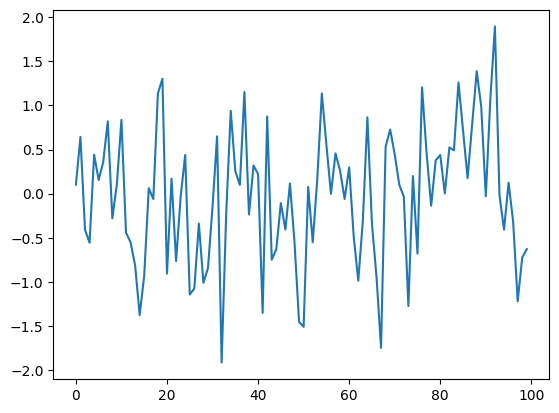

In [13]:
plt.plot(Y.cpu().numpy()[:100, 0])

## Test Data

In [14]:
## Change for filter

Y_test = torch.zeros(T, M).to(device)
X_test = torch.zeros(T, P).to(device)
E_test = torch.zeros(T, P).to(device)

for k in range(T):
  E_test[k:k+1, :] = torch.matmul(sig2_e0**0.5, torch.randn(P, 1).to(device)).T
  if k:
    if k > 1:
      X_test.data[k:k+1, :] = -b0.T*X_test.data[k-1:k, :] - d0.T*X_test.data[k-2:k-1, :] + E_test[k:k+1, :]
    else:
      X_test.data[k:k+1, :] = -b0.T*X_test.data[k-1:k, :] + E_test[k:k+1, :] 
  else:
    X_test.data[k:k+1, :] = torch.ones(1, P).to(device) * E_test[k:k+1, :]

In [15]:
Y_test, sig2_eps0 = likelihood0(X_test)
Y_test.data += (sig2_eps0**0.5) * torch.randn(T, M).to(device)

In [16]:
Y_test = Y_test[-N:, :].detach()
X_test = X_test[-N:, :].cpu().detach().numpy()

## Subspace Identification

In [17]:
# posterior = Posterior(M, P)
# likelihood = Likelihood(M, P)
# filter = Filter(P)

In [18]:
# likelihood.to(device)
# filter.to(device)
# posterior.to(device)

In [19]:
# optimizer_1 = torch.optim.Adam(posterior.parameters(), lr = 1e-3)
# optimizer_2 = torch.optim.Adam(nn.ModuleList([likelihood, filter]).parameters(), lr = 1e-3)

In [20]:
# import tqdm

In [21]:
# B = 10
# epochs = 100
# L = []
# iter = 10
# for epoch in tqdm.tqdm(range(epochs)):
#   for i in range(iter):
#     loss_val = loss(M, P, Y, posterior, likelihood, filter, B = B)
#     # L.append(loss_val.item())
#     loss_val.backward()
#     optimizer_1.step()
#     optimizer_1.zero_grad()
#   for i in range(iter):
#     loss_val = loss(M, P, Y, posterior, likelihood, filter, B = B)
#     L.append(loss_val.item())
#     loss_val.backward()
#     optimizer_2.step()
#     optimizer_2.zero_grad()

In [22]:
# plt.plot(L)
# plt.title('Negative average log-likelihood vs iterations')
# plt.ylabel('Negative average log-likelihood')
# plt.xlabel('iterations')

## Test Results

In [23]:
likelihood = torch.load('/kaggle/input/pasfa-evaluation-main/likelihood')
posterior = torch.load('/kaggle/input/pasfa-evaluation-main/posterior')
filter = torch.load('/kaggle/input/pasfa-evaluation-main/filter')

<ipython-input-23-b89c536bd2f1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  likelihood = torch.load('/kaggle/input/pasfa-evaluation-main/likelihood')
<ipython-input-23-

In [24]:
X_hat, var_posterior = posterior(Y_test)
Y_hat, sig2_eps = likelihood(X_hat)
b, d = filter()
Hk = get_Hk(b, d) # torch.diag((1 + (b**2 / (1 - (d - b)**2))).flatten())
sig2_e = torch.inverse(Hk)

In [25]:
X_hat = X_hat.cpu().detach().numpy()
Y_hat = Y_hat.cpu().detach().numpy()

In [26]:
Xcorr_PASFA = np.zeros((P, P))
Ycorr = np.zeros((M, M))

for i in range(P):
  for j in range(P):
    Xcorr_PASFA[i, j] = np.corrcoef(X_test[:, i], X_hat[:, j])[0, -1]

for i in range(M):
  for j in range(M):
    Ycorr[i, j] = np.corrcoef(Y_test.cpu().numpy()[:, i], Y_hat[:, j])[0, -1]

In [27]:
print(Xcorr_PASFA)

[[0.68900423]]


In [28]:
print(Ycorr)

[[1.]]


In [29]:
sig2_e

tensor([[0.8227]], grad_fn=<LinalgInvExBackward0>)

In [30]:
sig2_e0

tensor([[0.7577]], grad_fn=<LinalgInvExBackward0>)

In [31]:
b

tensor([[-0.3179]], grad_fn=<PermuteBackward0>)

In [32]:
b0

tensor([[-0.3352]], grad_fn=<PermuteBackward0>)

In [33]:
d

tensor([[-0.1792]], grad_fn=<PermuteBackward0>)

In [34]:
d0

tensor([[-0.2416]], grad_fn=<PermuteBackward0>)

In [35]:
sig2_eps

tensor(0.2798, grad_fn=<SqueezeBackward0>)

In [36]:
sig2_eps0

tensor(0.2955, grad_fn=<SqueezeBackward0>)

In [37]:
likelihood.fc1.weight

Parameter containing:
tensor([[0.5169]], requires_grad=True)

In [38]:
likelihood0.fc1.weight

Parameter containing:
tensor([[0.5253]], requires_grad=True)

# Generalized Kalman filter

In [39]:
import numpy as np
from numpy.polynomial import polynomial
import matplotlib.pyplot as plt

In [40]:
L = 1
M = 1
N = max(L, M + 1)
Z = max(L + 1, N)
P = 1
Q = 1
T = 2000

In [41]:
A = {1: np.diag((d - b).cpu().detach().numpy()[:, 0])}
B = {0: np.eye(P), 1: np.diag((-d).cpu().detach().numpy()[:, 0])}
C = likelihood.fc1.weight.cpu().detach().numpy().T
S2_e = sig2_e.cpu().detach().numpy()
S2_epsilon = sig2_eps.item()
Gex = np.zeros((P, T))
Gex[:, 0] = np.diag(S2_e)

In [42]:
x = X_test.T
y = Y_test.cpu().numpy().T

In [43]:
y.shape

(1, 2000)

In [44]:
for k in range(T):
    for l in range(1, L + 1):
        if k - l >= 0:
            Gex[:, k] += np.dot(A[l], Gex[:, k - l])

In [45]:
S = 0
for j in range(1, M + 1):
    for i in range(1, L + 1):
        if (i - j) <= 0:
            S += (2 * np.dot(np.dot(A[i], np.diag(Gex[:, j - i])), B[j].T))
    S += np.dot(S2_e, np.dot(B[j], B[j].T))
S += S2_e

In [46]:
P_hat = np.zeros((N + 1, Z, Z, P, P))
x_hat = np.zeros((N + 1, P, T))
P_arr = []
K_arr = []

In [47]:
def get_x_hat(i, j):
    return x_hat[j - i + N, :, i]

def get_P_hat(k, i, j, d):
    l = k - i
    m = k - j
    return P_hat[k - d, l, m]
    
def get_kalman_gain(k, i, j):
    l = k - i
    m = k - j
    Pij = get_P_hat(k, i, j, j - 1)
    Pjj = get_P_hat(k, j, j, j - 1)
    # print(np.linalg.det(np.dot(np.dot(C, Pjj), C.T) + S2_epsilon * np.eye(Q)))
    return np.dot(Pij, np.dot(C.T, np.linalg.inv(np.dot(np.dot(C, Pjj), C.T) + S2_epsilon * np.eye(Q))))

def get_x_hat_update(k, i, j):
    F = get_kalman_gain(k, i, j)
    error = y[:, j] - np.dot(C, get_x_hat(j, j - 1))
    return get_x_hat(i, j - 1) + np.dot(F, error)

def get_P_hat_update(k, i, j, d):
    return get_P_hat(k, i, j, d - 1) + \
           np.dot(np.dot(np.dot(np.dot(get_kalman_gain(k, i, d), C), get_P_hat(k, d, d, d - 1)), C.T), get_kalman_gain(k, j, d).T) + \
           S2_epsilon * np.dot(get_kalman_gain(k, i, d), get_kalman_gain(k, j, d).T) - \
           np.dot(np.dot(get_P_hat(k, i, d, d - 1), C.T), get_kalman_gain(k, j, d).T) - \
           np.dot(np.dot(get_kalman_gain(k, i, d), C), get_P_hat(k, j, d, d - 1).T)

In [48]:
for k in range(L, T):
    
    # Perform P update
    for l in range(N):
        for i in range(1, L + 1):
            if l:
                P_hat[N, 0, l] += np.dot(A[i], get_P_hat(k, k - i, k - l, k - N))
                P_hat[N, l, 0] += np.dot(A[i], get_P_hat(k, k - i, k - l, k - N))
            else:
                P_hat[N, 0, l] += np.dot(np.dot(A[i], get_P_hat(k, k - i, k - i, k - N)), A[i].T)
        if l:
            for i in range(1, M + 1):
                if (l - i) <= 0:
                    P_hat[N, 0, l] += np.dot(B[i], Gex[:, i - l])
                    P_hat[N, l, 0] += np.dot(B[i], Gex[:, i - l])
        else:
            P_hat[N, 0, l] += S
    for m in range(N - 1, -1, -1):
        for l in range(m + 1):
            P_hat[m, 0, l] = get_P_hat_update(k, k, k - l, k - m)
            P_hat[m, l, 0] = P_hat[m, 0, l].T
            
    # Perform x update 
    for i in range(1, L + 1):
        x_hat[0, :, k] += np.dot(A[i], get_x_hat(k - i, k - N))
    for l in range(N - 1, -1, -1):
        x_hat[N - l, :, k] = get_x_hat_update(k, k, k - l)

    # Refresh P
    P_arr.append(get_P_hat(k, k, k, k - 1)[0, 0])
    K_arr.append(get_kalman_gain(k, k, k)[0, 0])
    P_hat = np.concatenate((np.zeros((1, Z, Z, P, P)), P_hat[:-1]), axis = 0)
    for i in range(1, N + 1):
        temp = np.zeros((Z, Z, P, P))
        temp[1:, 1:] = P_hat[i, :-1, :-1]
        P_hat[i] = temp

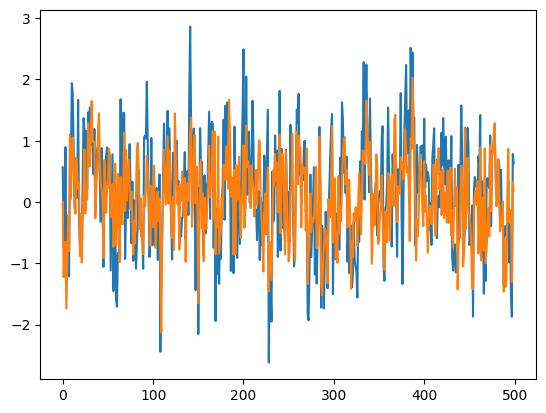

In [49]:
plt.plot(x[0, :500])
plt.plot(x_hat[N, 0, :500])

In [50]:
Xcorr_rec_PASFA = np.zeros((P, P))

for i in range(P):
  for j in range(P):
    Xcorr_rec_PASFA[i, j] = np.corrcoef(x[i, :], x_hat[N, j, :])[0, -1]

In [51]:
Xcorr_rec_PASFA

array([[0.70536811]])

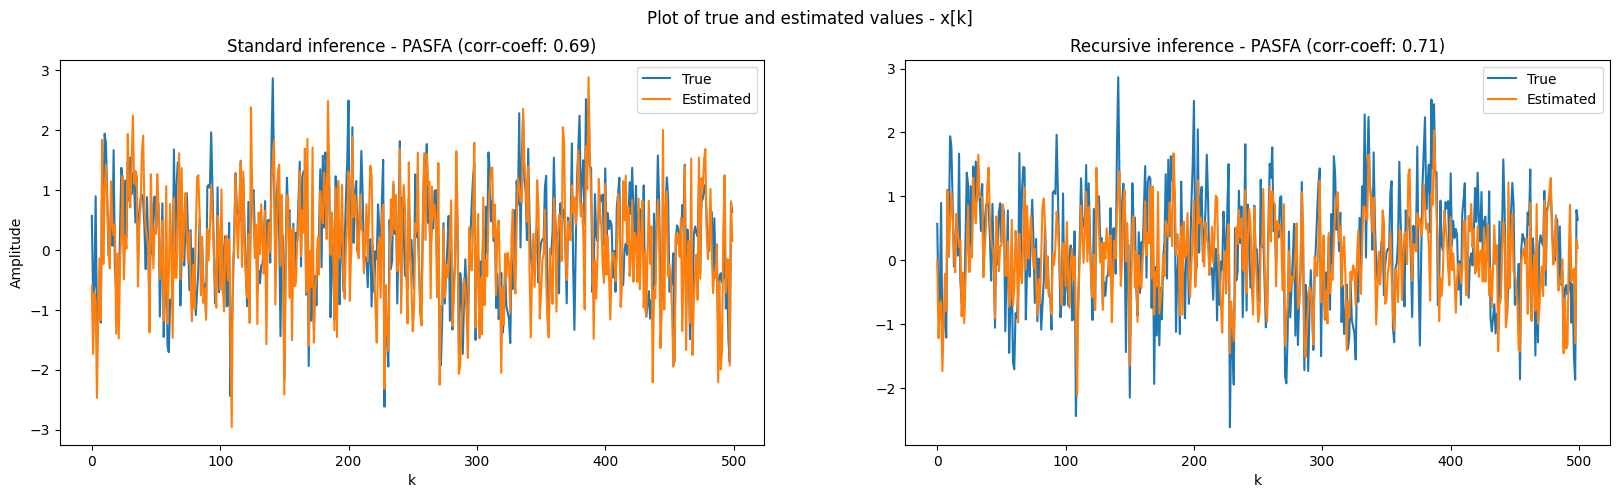

In [63]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ax[0].plot(X_test[:500, 0], label = 'True')
ax[0].plot(X_hat[:500, 0], label = 'Estimated')
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('Amplitude')
ax[0].title.set_text('Standard inference - PASFA (corr-coeff: {})'.format(round(Xcorr_PASFA[0, 0], 2)))

ax[1].plot(x[0, :500], label = 'True')
ax[1].plot(x_hat[N, 0, :500], label = 'Estimated')
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].title.set_text('Recursive inference - PASFA (corr-coeff: {})'.format(round(Xcorr_rec_PASFA[0, 0], 2)))

plt.suptitle('Plot of true and estimated values - x[k]')

plt.savefig('a.png')

In [53]:
np.sum((X_hat - X_test) ** 2) / T

0.6229520874023438

In [54]:
np.sum((x_hat[N] - x) ** 2) / T

0.5087165183631753

In [55]:
# 0.73, 0.7, 0.71, 0.71, 0.7, 0.69, 0.68, 0.69, 0.67, 0.68
# 0.75, 0.72, 0.73, 0.73, 0.71, 0.7, 0.69, 0.7, 0.69, 0.7
# 0.5783670654296875, 0.592220703125, 0.5726705322265625, 0.6152080078125, 0.5930416259765625, 0.6006102294921875, 0.631458984375, 0.5926788330078125, 0.615731689453125, 0.613736328125
# 0.4944390943316865, 0.4716108359858854, 0.4721103412084753, 0.49637554674384443, 0.4959270451404318, 0.4924105658020609, 0.5025464101498034, 0.48408573895402046, 0.4882446803375426, 0.47229642773131963

In [56]:
# torch.save(likelihood0, 'likelihood0')
# torch.save(filter0, 'filter0')

# torch.save(likelihood, 'likelihood')
# torch.save(posterior, 'posterior')
# torch.save(filter, 'filter')